In [1]:
# %%
import os
import pickle
import time
from functools import partial

import torch

from dgp import get_dataloader
from utils.default_device import get_default_device
from utils.llc import calculate_llc_for_file, evaluate_fn
from utils.loading import Conf, load_model_from_hf
import torch.nn.functional as F
from utils import move_to_device
from tqdm import tqdm

from torch.utils.data import DataLoader, TensorDataset



In [2]:
# %%

# device = "cpu"
device = get_default_device()

hf_repo_name = "cybershiptrooper/ConceptPerlocation_ckpts_98k"
dump_dir = f"results/scratch/{hf_repo_name}/llc"
model_dir = f"results/scratch/{hf_repo_name}"


os.makedirs(dump_dir, exist_ok=True)


In [3]:
# %%

model = load_model_from_hf(0, hf_repo_name, epoch=0)
config = Conf(**model["config"])

config.device = device

dataloader = get_dataloader(
    n_relative_properties=config.data.n_relative_properties,
    n_descriptive_properties=config.data.n_descriptive_properties,
    n_descriptive_values=config.data.n_descriptive_values,
    num_of_classes_to_divide_over=config.data.num_of_classes_to_divide_over,
    prior_param=config.data.prior_param,
    props_prior_type=config.data.props_prior_type,
    n_entities=config.data.n_entities,
    instr_ratio=config.data.instr_ratio,
    max_sample_length=config.data.max_sample_length,
    num_iters=5e5 * config.data.batch_size,
    batch_size=config.data.batch_size,
    num_workers=config.data.num_workers,
    seed=config.seed,
)
pad_token_id = dataloader.dataset.pad_token_id

all_inputs = []
all_labels = []
all_masks = []
for i, batch in tqdm(enumerate(dataloader)):
    if i > 1000:
        break
    sequences, symb_sequences, seq_lengths, seq_logprobs, _ = batch
    inputs = sequences[:, :-1]
    labels = sequences[:, 1:].clone()
    # procesed_batch = [inputs, labels]
    all_inputs.append(inputs)
    all_labels.append(labels)

    mask = (labels != pad_token_id).float()
    all_masks.append(mask)

# make a dataset with all the inputs and labels
print("Making a new dataloader with all the data")
all_inputs = torch.cat(all_inputs, dim=0)
all_labels = torch.cat(all_labels, dim=0)
all_masks = torch.cat(all_masks, dim=0)
print(all_inputs.shape, all_labels.shape)
print(all_inputs.device, all_labels.device)
new_dataloader = DataLoader(
    TensorDataset(all_inputs, all_labels, all_masks),
    batch_size=config.data.batch_size,
    num_workers=config.data.num_workers,
    shuffle=True,
)
print("Done making the new dataloader")

/Users/cybershiptrooper/src/interpretability/devinterp/timaeus/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/cybershiptrooper/src/interpretability/devinterp/timaeus/projects/power-laws/src/ConceptPercolation/utils/loading.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode 

Making a new dataloader with all the data
torch.Size([128128, 74]) torch.Size([128128, 74])
cpu cpu
Done making the new dataloader


In [4]:
# %%
from utils.llc import evaluate_fn
evaluator = evaluate_fn


In [6]:
# %%

llc_outputs = []
iters = (
    list(range(0, 200, 10))
    + list(range(200, 1200, 20))
    + list(range(1200, 5_001, 50))
    + list(range(5_100, 10_001, 100))
    + list(range(10_500, 25_501, 500))
    + list(range(26_000, 100_501, 1000))
)
iters = [2000, 20000]
for iter in tqdm(iters):
    print(f"Calculating LLC for iteration {iter}")
    time_now = time.time()
    llc_output = calculate_llc_for_file(
        iter,
        new_dataloader,
        model_dir=hf_repo_name,
        config=config,
        evaluate_fn=evaluator,
        model_loader=load_model_from_hf,
        num_chains=5,
        num_draws=200,
        vocab_size=dataloader.dataset.PCSG.vocab_size,
    )
    time_taken = time.time() - time_now
    # print formatted time
    print(f"Time taken: {time_taken//60:.0f}m {time_taken%60:.0f}s")
    llc_outputs.append(llc_output)
    with open(f"{dump_dir}/llc_output_it_{iter}.pkl", "wb") as f:
        pickle.dump(llc_output, f)


  0%|          | 0/2 [00:00<?, ?it/s]

Calculating LLC for iteration 2000


/Users/cybershiptrooper/src/interpretability/devinterp/timaeus/projects/power-laws/src/ConceptPercolation/utils/loading.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Time taken: 1m 47s
Calculating LLC for iteration 20000


100%|██████████| 2/2 [03:16<00:00, 98.05s/it] 

Time taken: 1m 29s


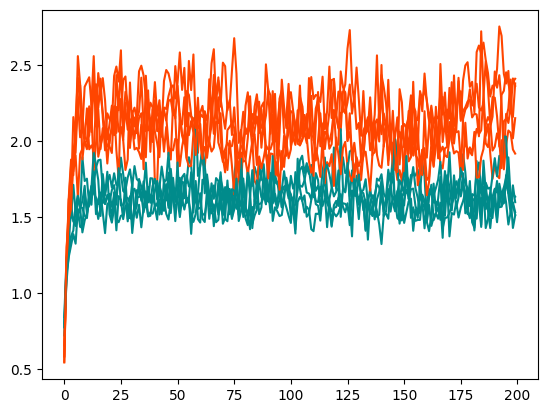

In [7]:
import matplotlib.pyplot as plt

for i in range(llc_outputs[0]["loss/trace"].shape[0]):
    plt.plot(llc_outputs[0]["loss/trace"][i], color="darkcyan")
    plt.plot(llc_outputs[1]["loss/trace"][i], color="orangered")



In [8]:
[llc_outputs[i]["llc/mean"] for i in range(len(llc_outputs))]

[26.508342742919922, 44.38850784301758]